# ML Coursework

### Importing the modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [3]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import MultinomialNB
from scipy import stats
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from time import time as tt

In [4]:
%%capture
# we use %%capture to suppress the output. Comment the line above if you're working on local machine
# install spacy
!pip install --upgrade spacy
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_md
!pip install clean-text


In [5]:
import spacy
from cleantext import clean

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


### Performing EDA on the available dataset

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')
# data = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/comp1804_coursework_dataset_24-25.csv")
data = pd.read_csv("comp1804_coursework_dataset_24-25.csv")
data.head()

,petition_ID,has_entity,relevant_department,deviation_across_regions,petition_status,petition_topic,petition_importance,petition_text
0,607158,EVENT:NO_DATE:NO_PERSON:NO_,Department for Education,0.000137,unsuccessful,education,not_important,Ban school uniforms in English schools. I want...
1,590629,EVENT:NO_DATE:YES_PERSON:NO_,Department of Health and Social Care,0.002133,unsuccessful,uk government and devolution,important,Lock NHS pay rises to increases in pay for MPs...
2,652724,EVENT:NO_DATE:NO_PERSON:NO_,Department of Health and Social Care,0.000272,unsuccessful,health and social care,important,Require dose counters on SABA metered dose inh...
3,629281,EVENT:NO_DATE:NO_PERSON:NO_,HM Treasury,0.000083,unsuccessful,"economy, labour and welfare",not_important,Remove the 20% VAT on private dementia day car...
4,301747,EVENT:NO_DATE:NO_PERSON:NO_,NaN,NaN,rejected,"culture, sport and media",not_important,Make bank holidays a holiday. Make bank holida...


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8520 entries, 0 to 8897
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   petition_ID               8520 non-null   int64  
 1   has_entity                8520 non-null   object 
 2   relevant_department       6724 non-null   object 
 3   deviation_across_regions  6943 non-null   float64
 4   petition_status           8520 non-null   object 
 5   petition_topic            8489 non-null   object 
 6   petition_importance       20 non-null     object 
 7   petition_text             8518 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 599.1+ KB


In [73]:
data["petition_topic"].value_counts().index

Index(['environment and animal welfare', 'health and social care',
       'economy, labour and welfare', 'education', 'culture, sport and media',
       'uk government and devolution', 'london', 'Health And Social Care',
       'Environment And Animal Welfare', 'Economy, Labour And Welfare',
       'Education', 'Culture, Sport And Media', 'Uk Government And Devolution',
       'London'],
      dtype='object', name='petition_topic')

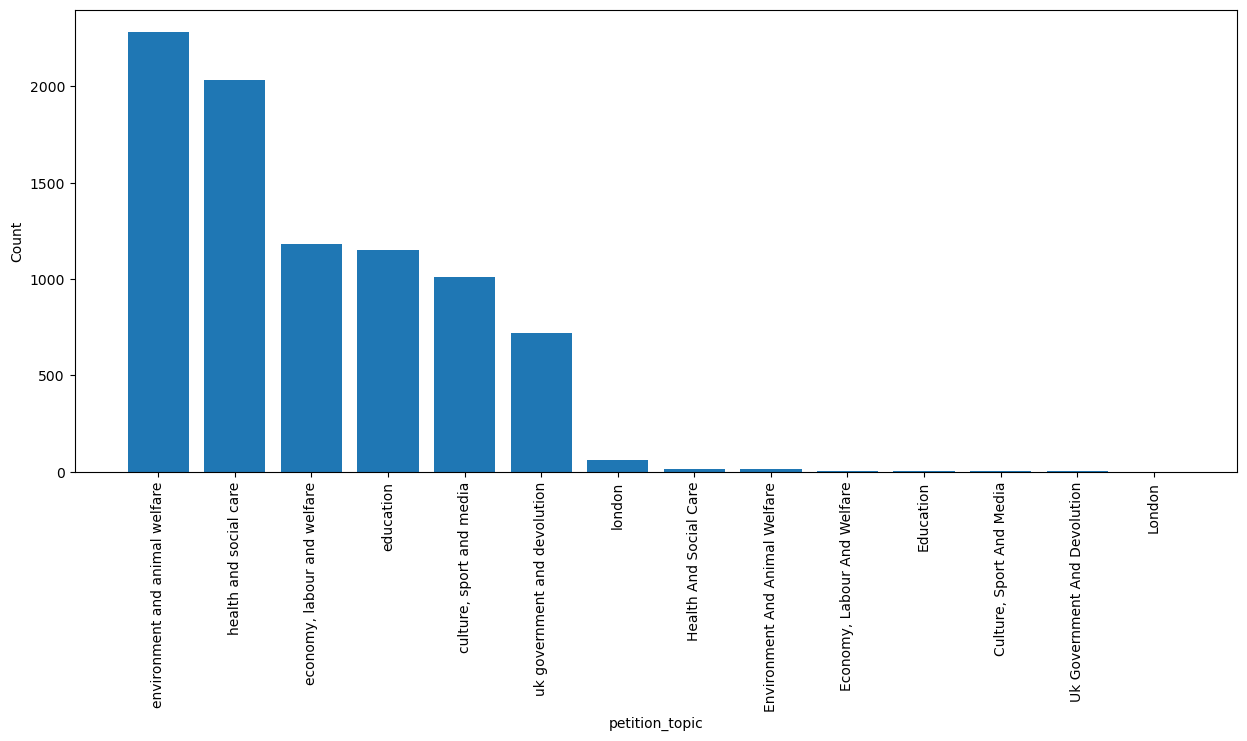

In [84]:
plt.figure(figsize=(15, 6))
plt.bar(data["petition_topic"].value_counts().index,height=data["petition_topic"].value_counts(), align='center')
plt.xticks(data["petition_topic"].value_counts().index, rotation = 90,)
plt.xlabel('petition_topic', fontsize=10)
plt.ylabel('Count', fontsize=10,rotation=90)
plt.show()

### Split the data into train and test before performing data cleaning on it

In [6]:
duplicates_rows = data.duplicated()
# The result is True for rows that are a duplicate, False for rows that are not a duplicate

print(f'There are {duplicates_rows.sum()} duplicates rows.')

# We have no duplicates here,
# but if we had them, to remove them we'd only keep the rows that are NOT duplicates
data = data[~duplicates_rows]

There are 378 duplicates rows.


In [7]:
train_data,test_data = train_test_split(data, test_size=0.15)

In [8]:
print(train_data.head(5))

      petition_ID                    has_entity  \
7295       643417   EVENT:NO_DATE:NO_PERSON:NO_   
3265       603349   EVENT:NO_DATE:NO_PERSON:NO_   
2197       622551   EVENT:NO_DATE:NO_PERSON:NO_   
7211       700916  EVENT:NO_DATE:YES_PERSON:NO_   
2112       633096   EVENT:NO_DATE:NO_PERSON:NO_   

                                    relevant_department  \
7295       Office of the Leader of the House of Commons   
3265               Department of Health and Social Care   
2197  Department for Environment, Food and Rural Aff...   
7211                                                NaN   
2112  Department for Environment, Food and Rural Aff...   

      deviation_across_regions petition_status  \
7295                  0.000185    unsuccessful   
3265                  0.000092    unsuccessful   
2197                  0.000419    unsuccessful   
7211                       NaN        rejected   
2112                  0.000098    unsuccessful   

                      petition_topic 

In [9]:
print(test_data.head())

      petition_ID                    has_entity  \
2231       307517  EVENT:NO_DATE:YES_PERSON:NO_   
1688       607566   EVENT:NO_DATE:NO_PERSON:NO_   
8441       553127  EVENT:NO_DATE:NO_PERSON:YES_   
7746       302292   EVENT:NO_DATE:NO_PERSON:NO_   
8711       308227   EVENT:NO_DATE:NO_PERSON:NO_   

                       relevant_department  deviation_across_regions  \
2231                                   NaN                       NaN   
1688  Department of Health and Social Care                  0.000211   
8441              Department for Transport                  0.000718   
7746                                   NaN                       NaN   
8711  Department of Health and Social Care                       NaN   

     petition_status                  petition_topic petition_importance  \
2231        rejected  environment and animal welfare                 NaN   
1688    unsuccessful          health and social care                 NaN   
8441    unsuccessful          he

### Perform clean up and EDA on both train and test data

In [10]:
train_data.petition_topic.value_counts()

petition_topic
environment and animal welfare    1943
health and social care            1702
economy, labour and welfare       1028
education                          990
culture, sport and media           855
uk government and devolution       611
london                              48
Health And Social Care              14
Environment And Animal Welfare      10
Economy, Labour And Welfare          6
Culture, Sport And Media             5
Uk Government And Devolution         2
London                               1
Education                            1
Name: count, dtype: int64

A lot of similar petition topics (classes in this case) but differentiated because of case sensitivity, so data cleaning is required so that only
7 distinct classes exist in this

In [11]:
train_data.loc[train_data.petition_topic=='Health And Social Care','petition_topic'] = 'health and social care'

train_data.loc[train_data.petition_topic=='Environment And Animal Welfare','petition_topic'] = 'environment and animal welfare'

train_data.loc[train_data.petition_topic=='Economy, Labour And Welfare','petition_topic'] = 'economy, labour and welfare'

train_data.loc[train_data.petition_topic=='Education','petition_topic'] = 'education'

train_data.loc[train_data.petition_topic=='Culture, Sport And Media','petition_topic'] = 'culture, sport and media'

train_data.loc[train_data.petition_topic=='Uk Government And Devolution','petition_topic'] = 'uk government and devolution'

train_data.loc[train_data.petition_topic=='London','petition_topic'] = 'london'

In [12]:
train_data.petition_topic.value_counts()

petition_topic
environment and animal welfare    1953
health and social care            1716
economy, labour and welfare       1034
education                          991
culture, sport and media           860
uk government and devolution       613
london                              49
Name: count, dtype: int64

Similarly on the test data

In [13]:
test_data.petition_topic.value_counts()

petition_topic
environment and animal welfare    341
health and social care            329
education                         163
culture, sport and media          157
economy, labour and welfare       156
uk government and devolution      108
london                             11
Education                           4
Environment And Animal Welfare      3
Health And Social Care              1
Name: count, dtype: int64

In [14]:
test_data.loc[test_data.petition_topic=='Health And Social Care','petition_topic'] = 'health and social care'

test_data.loc[test_data.petition_topic=='Environment And Animal Welfare','petition_topic'] = 'environment and animal welfare'

test_data.loc[test_data.petition_topic=='Economy, Labour And Welfare','petition_topic'] = 'economy, labour and welfare'

test_data.loc[test_data.petition_topic=='Education','petition_topic'] = 'education'

test_data.loc[test_data.petition_topic=='Culture, Sport And Media','petition_topic'] = 'culture, sport and media'

test_data.loc[test_data.petition_topic=='Uk Government And Devolution','petition_topic'] = 'uk government and devolution'

test_data.loc[test_data.petition_topic=='London','petition_topic'] = 'london'

In [15]:
test_data.petition_topic.value_counts()

petition_topic
environment and animal welfare    344
health and social care            330
education                         167
culture, sport and media          157
economy, labour and welfare       156
uk government and devolution      108
london                             11
Name: count, dtype: int64

There appears to be imbalance in the dataset

Check for missing data in both train and test datas

In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7242 entries, 7295 to 2730
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   petition_ID               7242 non-null   int64  
 1   has_entity                7242 non-null   object 
 2   relevant_department       5719 non-null   object 
 3   deviation_across_regions  5907 non-null   float64
 4   petition_status           7242 non-null   object 
 5   petition_topic            7216 non-null   object 
 6   petition_importance       19 non-null     object 
 7   petition_text             7240 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 509.2+ KB


In [17]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1278 entries, 2231 to 7562
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   petition_ID               1278 non-null   int64  
 1   has_entity                1278 non-null   object 
 2   relevant_department       1005 non-null   object 
 3   deviation_across_regions  1036 non-null   float64
 4   petition_status           1278 non-null   object 
 5   petition_topic            1273 non-null   object 
 6   petition_importance       1 non-null      object 
 7   petition_text             1278 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 89.9+ KB


In [18]:
train_data.head(50)

,petition_ID,has_entity,relevant_department,deviation_across_regions,petition_status,petition_topic,petition_importance,petition_text
7295,643417,EVENT:NO_DATE:NO_PERSON:NO_,Office of the Leader of the House of Commons,0.000185,unsuccessful,uk government and devolution,NaN,Require approval through a referendum before a...
3265,603349,EVENT:NO_DATE:NO_PERSON:NO_,Department of Health and Social Care,0.000092,unsuccessful,health and social care,NaN,Fund access to free period products for homele...
2197,622551,EVENT:NO_DATE:NO_PERSON:NO_,"Department for Environment, Food and Rural Aff...",0.000419,unsuccessful,environment and animal welfare,NaN,Ban the release of any untreated raw sewage an...
7211,700916,EVENT:NO_DATE:YES_PERSON:NO_,NaN,NaN,rejected,environment and animal welfare,NaN,Allow use of fireworks on only Bonfire Night ...
2112,633096,EVENT:NO_DATE:NO_PERSON:NO_,"Department for Environment, Food and Rural Aff...",0.000098,unsuccessful,environment and animal welfare,NaN,Give councils powers to tax takeaway packaging...
1802,625216,EVENT:NO_DATE:NO_PERSON:NO_,Cabinet Office,0.000079,unsuccessful,uk government and devolution,NaN,Form an emergency coalition Government. We cal...
1646,586582,EVENT:NO_DATE:NO_PERSON:YES_,Department for Transport,0.000378,unsuccessful,environment and animal welfare,NaN,Include vehicle battery and charger manufactur...
2806,622134,EVENT:NO_DATE:YES_PERSON:NO_,Department for Transport,0.000076,unsuccessful,environment and animal welfare,NaN,Stop charging double vehicle tax for the month...
3879,641910,EVENT:NO_DATE:NO_PERSON:YES_,Department for Transport,0.000183,unsuccessful,"economy, labour and welfare",NaN,Make private hire taxis and hackney cabs zero-...
2571,553375,EVENT:NO_DATE:YES_PERSON:YES_,Department for Work and Pensions,0.000050,unsuccessful,"economy, labour and welfare",NaN,Voluntary early retirement at 60 with reduced ...


### the topic to predict is in the column: “petition_topic”. The input features to use are: “petition_text” and “has_entity”

In [19]:
train_data[["has_entity","petition_topic","petition_text"]].isna().sum()

has_entity         0
petition_topic    26
petition_text      2
dtype: int64

In [20]:
test_data[["has_entity","petition_topic","petition_text"]].isna().sum()

has_entity        0
petition_topic    5
petition_text     0
dtype: int64

since the petition_topic is the target variable, I will be droping the missing values whereas the petition_text is missing in only 2 records, I am dropping that too

In [21]:
train_data = train_data.dropna(subset=["petition_topic"])
train_data = train_data.dropna(subset=["petition_text"])

In [22]:
test_data = test_data.dropna(subset=["petition_topic"])
test_data = test_data.dropna(subset=["petition_text"])

In [23]:
train_data[["has_entity","petition_topic","petition_text"]].isna().sum()

has_entity        0
petition_topic    0
petition_text     0
dtype: int64

In [24]:
test_data[["has_entity","petition_topic","petition_text"]].isna().sum()

has_entity        0
petition_topic    0
petition_text     0
dtype: int64

In [25]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7214 entries, 7295 to 2730
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   petition_ID               7214 non-null   int64  
 1   has_entity                7214 non-null   object 
 2   relevant_department       5697 non-null   object 
 3   deviation_across_regions  5885 non-null   float64
 4   petition_status           7214 non-null   object 
 5   petition_topic            7214 non-null   object 
 6   petition_importance       19 non-null     object 
 7   petition_text             7214 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 507.2+ KB


In [26]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1273 entries, 2231 to 7562
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   petition_ID               1273 non-null   int64  
 1   has_entity                1273 non-null   object 
 2   relevant_department       1001 non-null   object 
 3   deviation_across_regions  1031 non-null   float64
 4   petition_status           1273 non-null   object 
 5   petition_topic            1273 non-null   object 
 6   petition_importance       1 non-null      object 
 7   petition_text             1273 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 89.5+ KB


In [27]:
train_data.isna().sum()

petition_ID                    0
has_entity                     0
relevant_department         1517
deviation_across_regions    1329
petition_status                0
petition_topic                 0
petition_importance         7195
petition_text                  0
dtype: int64

In [28]:
mod_train_data = train_data.drop(columns=["relevant_department","deviation_across_regions","petition_importance"])
mod_test_data= test_data.drop(columns=["relevant_department","deviation_across_regions","petition_importance"])

## Now to clean and tokenize the petition_text column

In [29]:
print('How many texts have the newline character "\\n"?')

print("train: ", mod_train_data['petition_text'].str.contains("\n").sum())
print("test: ",mod_test_data['petition_text'].str.contains("\n").sum())

How many texts have the newline character "\n"?
train:  2746
test:  492


In [30]:
from cleantext import clean

def clean_text(x):
  """ Define standard cleaning procedure """
  return clean(x,
    fix_unicode=True,               # fix various unicode errors
    lower=True,                     # change all text to lowercase
    no_line_breaks=True,           # this removes occurrences of the newline character "\n"
    no_punct=False,                 # let's NOT remove punctuations for the time being
    no_urls=True,                  # replace all URLs with a special token (below)
    replace_with_url="",          # we decide to replace urls with nothing
    no_emails=True,                # replace all email addresses with a special token
    replace_with_email="",        # we decide to replace emails with nothing
    no_phone_numbers=True,         # replace all phone numbers with a special token
    replace_with_phone_number="",   # we decide to replace phone numbers with nothing
    lang="en"                       # set to 'de' for German special handling
    )


Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [31]:
mod_train_data['clean_text']= mod_train_data['petition_text'].apply(clean_text)
mod_test_data['clean_text']= mod_test_data['petition_text'].apply(clean_text)

#### Lets tokenize the text

In [32]:
import string
EXTRA_PUNCT = string.punctuation

# import Spacy
import spacy
# create the Spacy pipeline
nlp = spacy.load('en_core_web_sm')

def preprocess_text_with_spacy(text_):
  doc_ = nlp(text_)
  lemmas_ = [token.lemma_ for token in doc_ if not (token.is_stop or token.is_punct or token.is_digit)]
  return [lemma for lemma in lemmas_ if lemma not in EXTRA_PUNCT]


In [33]:
from time import time as tt
t0 = tt()
mod_train_data['tokenized_text'] = mod_train_data['clean_text'].apply(preprocess_text_with_spacy)
print(f'Time elapsed is {(tt()-t0):.2f} seconds')

Time elapsed is 162.20 seconds


In [34]:
from time import time as tt
t0 = tt()
mod_test_data['tokenized_text'] = mod_test_data['clean_text'].apply(preprocess_text_with_spacy)
print(f'Time elapsed is {(tt()-t0):.2f} seconds')

Time elapsed is 29.24 seconds


In [35]:
mod_train_data['text_length'] = mod_train_data['clean_text'].apply(len)
mod_test_data['text_length'] = mod_test_data['clean_text'].apply(len)

In [36]:
mod_train_data.head()

,petition_ID,has_entity,petition_status,petition_topic,petition_text,clean_text,tokenized_text,text_length
7295,643417,EVENT:NO_DATE:NO_PERSON:NO_,unsuccessful,uk government and devolution,Require approval through a referendum before a...,require approval through a referendum before a...,"[require, approval, referendum, legislation, p...",814
3265,603349,EVENT:NO_DATE:NO_PERSON:NO_,unsuccessful,health and social care,Fund access to free period products for homele...,fund access to free period products for homele...,"[fund, access, free, period, product, homeless...",612
2197,622551,EVENT:NO_DATE:NO_PERSON:NO_,unsuccessful,environment and animal welfare,Ban the release of any untreated raw sewage an...,ban the release of any untreated raw sewage an...,"[ban, release, untreated, raw, sewage, separat...",868
7211,700916,EVENT:NO_DATE:YES_PERSON:NO_,rejected,environment and animal welfare,Allow use of fireworks on only Bonfire Night ...,allow use of fireworks on only bonfire night o...,"[allow, use, firework, bonfire, night, saturda...",446
2112,633096,EVENT:NO_DATE:NO_PERSON:NO_,unsuccessful,environment and animal welfare,Give councils powers to tax takeaway packaging...,give councils powers to tax takeaway packaging...,"[council, power, tax, takeaway, packaging, fun...",676


Utilizing the compute_avg_lemma_embedding learnt from the class to process and remove all stopwords and punctuations for a more accurate representation of the text, while filtering out unimportant words

In [37]:
# let's create a nice function to tokenize a single text document
import string
EXTRA_PUNCT = string.punctuation
# import Spacy
import spacy
# create the Spacy pipeline
nlp = spacy.load('en_core_web_md')

In [38]:
def compute_avg_lemma_embedding(text_):
  doc_ = nlp(text_)
  avg_embedding = np.zeros_like(doc_.vector)
  token_counter = 0
  for token in doc_:
    if (token.is_stop or token.is_punct or token.is_digit or (token.lemma_ in EXTRA_PUNCT)):
        continue
    avg_embedding += token.vector
    token_counter+=1

  if token_counter>0:
    avg_embedding = avg_embedding/token_counter
  return avg_embedding

In [39]:
from time import time as tt
t0 = tt()
df_train_emb = mod_train_data['clean_text'].apply(lambda x:  pd.Series(compute_avg_lemma_embedding(x)))
# 3. since they have the same index we can join the dataframe with the word embeddings with the old one
df_train_new = df_train_emb.join(mod_train_data[['text_length','petition_topic','clean_text']])
# the next line is just because scikit-learn doesn't like column names that are not strings
df_train_new.columns = df_train_new.columns.astype(str)
print(f'Time elapsed is {(tt()-t0):.2f} seconds')


Time elapsed is 178.55 seconds


In [40]:
t0 = tt()
df_test_emb = mod_test_data['clean_text'].apply(lambda x: pd.Series(compute_avg_lemma_embedding(x)))
df_test_new = df_test_emb.join(mod_test_data[['text_length','petition_topic','clean_text']])
df_test_new.columns = df_test_new.columns.astype(str)
print(f'Time elapsed is {(tt()-t0):.2f} seconds')


Time elapsed is 33.52 seconds


In [41]:
df_train_new.head()

,0,1,2,3,4,5,6,7,8,9,...,293,294,295,296,297,298,299,text_length,petition_topic,clean_text
7295,-0.697678,0.185375,-0.091277,-0.126126,-0.220019,0.012084,0.005238,0.041204,0.001177,2.211210,...,-0.005407,0.091535,0.119786,0.003236,-0.049077,-0.003821,-0.048717,814,uk government and devolution,require approval through a referendum before a...
3265,-0.699345,0.155080,-0.106308,-0.195413,-0.196017,-0.000001,0.052694,0.036451,-0.013616,1.878929,...,-0.006422,0.027194,0.152057,-0.003623,-0.139456,0.037091,0.134160,612,health and social care,fund access to free period products for homele...
2197,-0.699077,0.079179,-0.013301,-0.057155,-0.204882,0.166848,-0.027619,-0.047821,-0.169002,1.689985,...,-0.015640,-0.063799,-0.077822,-0.107109,-0.122873,-0.010499,-0.085356,868,environment and animal welfare,ban the release of any untreated raw sewage an...
7211,-0.695946,0.123124,-0.228428,-0.079207,-0.200550,0.033386,-0.051921,0.010060,0.079538,1.681540,...,0.057730,0.060563,0.191853,-0.064205,-0.116561,-0.037969,0.126331,446,environment and animal welfare,allow use of fireworks on only bonfire night o...
2112,-0.728280,0.120281,0.093123,-0.193406,-0.054578,0.085661,0.012411,-0.057791,0.166890,1.633869,...,-0.061955,-0.081188,0.074621,0.094284,-0.262580,0.153490,0.098370,676,environment and animal welfare,give councils powers to tax takeaway packaging...



I believe the data in has_entity is similar to the soil type data was already split into numeric types in the table from week 4 lab work or gender from week 3 of the lab work, which was split into numeric values using Encoders, basically that can help in using it as a feature.

The has_entity column can be split into has_event, has_date, has_person columns and after that its a true or false event which can be written as 1's and 0's while categorizing data_missing as NULL?


We can also convert the petition_topic into numerical data, which can be done using label encoder, we could use col transformers and get inidivdual columns for each of the classes in the table, but I believe that will be useful for neural networks, we can use a label encoder for MLP

In [42]:
from sklearn.preprocessing import LabelEncoder

lblEncoder_X = LabelEncoder()

lblEncoder_X = lblEncoder_X.fit(df_train_new['petition_topic']) # we can fit and transform all at once
df_train_new['petition_topic'] = lblEncoder_X.transform(df_train_new['petition_topic'])

print(df_train_new['petition_topic'])
print()
lblEncoder_Y = LabelEncoder()

lblEncoder_Y = lblEncoder_Y.fit(df_test_new['petition_topic']) # we can fit and transform all at once
df_test_new['petition_topic'] = lblEncoder_Y.transform(df_test_new['petition_topic'])

print(df_test_new['petition_topic'])


7295    6
3265    4
2197    3
7211    3
2112    3
       ..
5792    1
7996    3
8168    3
8863    6
2730    3
Name: petition_topic, Length: 7214, dtype: int32

2231    3
1688    4
8441    4
7746    2
8711    4
       ..
7387    6
2960    4
2031    4
6434    0
7562    1
Name: petition_topic, Length: 1273, dtype: int32


In [43]:
df_train_new.head()

,0,1,2,3,4,5,6,7,8,9,...,293,294,295,296,297,298,299,text_length,petition_topic,clean_text
7295,-0.697678,0.185375,-0.091277,-0.126126,-0.220019,0.012084,0.005238,0.041204,0.001177,2.211210,...,-0.005407,0.091535,0.119786,0.003236,-0.049077,-0.003821,-0.048717,814,6,require approval through a referendum before a...
3265,-0.699345,0.155080,-0.106308,-0.195413,-0.196017,-0.000001,0.052694,0.036451,-0.013616,1.878929,...,-0.006422,0.027194,0.152057,-0.003623,-0.139456,0.037091,0.134160,612,4,fund access to free period products for homele...
2197,-0.699077,0.079179,-0.013301,-0.057155,-0.204882,0.166848,-0.027619,-0.047821,-0.169002,1.689985,...,-0.015640,-0.063799,-0.077822,-0.107109,-0.122873,-0.010499,-0.085356,868,3,ban the release of any untreated raw sewage an...
7211,-0.695946,0.123124,-0.228428,-0.079207,-0.200550,0.033386,-0.051921,0.010060,0.079538,1.681540,...,0.057730,0.060563,0.191853,-0.064205,-0.116561,-0.037969,0.126331,446,3,allow use of fireworks on only bonfire night o...
2112,-0.728280,0.120281,0.093123,-0.193406,-0.054578,0.085661,0.012411,-0.057791,0.166890,1.633869,...,-0.061955,-0.081188,0.074621,0.094284,-0.262580,0.153490,0.098370,676,3,give councils powers to tax takeaway packaging...


In [44]:
df_train_check = df_train_new.copy()
df_test_check = df_test_new.copy()

In [45]:
df_train_check.head()

,0,1,2,3,4,5,6,7,8,9,...,293,294,295,296,297,298,299,text_length,petition_topic,clean_text
7295,-0.697678,0.185375,-0.091277,-0.126126,-0.220019,0.012084,0.005238,0.041204,0.001177,2.211210,...,-0.005407,0.091535,0.119786,0.003236,-0.049077,-0.003821,-0.048717,814,6,require approval through a referendum before a...
3265,-0.699345,0.155080,-0.106308,-0.195413,-0.196017,-0.000001,0.052694,0.036451,-0.013616,1.878929,...,-0.006422,0.027194,0.152057,-0.003623,-0.139456,0.037091,0.134160,612,4,fund access to free period products for homele...
2197,-0.699077,0.079179,-0.013301,-0.057155,-0.204882,0.166848,-0.027619,-0.047821,-0.169002,1.689985,...,-0.015640,-0.063799,-0.077822,-0.107109,-0.122873,-0.010499,-0.085356,868,3,ban the release of any untreated raw sewage an...
7211,-0.695946,0.123124,-0.228428,-0.079207,-0.200550,0.033386,-0.051921,0.010060,0.079538,1.681540,...,0.057730,0.060563,0.191853,-0.064205,-0.116561,-0.037969,0.126331,446,3,allow use of fireworks on only bonfire night o...
2112,-0.728280,0.120281,0.093123,-0.193406,-0.054578,0.085661,0.012411,-0.057791,0.166890,1.633869,...,-0.061955,-0.081188,0.074621,0.094284,-0.262580,0.153490,0.098370,676,3,give councils powers to tax takeaway packaging...


### Next step creation of a pipeline

In [46]:
# extract the target
y_train = df_train_check["petition_topic"]
y_test = df_test_check["petition_topic"]

petition_categories = ["environment and animal welfare","health and social care","economy, labour and welfare","education","culture, sport and media","uk government and devolution","london"]

Drop the clean text as the word embedding already exists

C:\Users\Ganesh\anaconda3\envs\Pandas_Playground_Updated\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ganesh\anaconda3\envs\Pandas_Playground_Updated\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ganesh\anaconda3\envs\Pandas_Playground_Updated\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ganesh\anaconda3\envs\Pandas_Playground_Updated\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and 

Time taken to train gridsearch: 1806.24 seconds.
                                precision    recall  f1-score   support

environment and animal welfare       0.59      0.83      0.69       157
        health and social care       0.69      0.66      0.67       156
   economy, labour and welfare       0.79      0.83      0.81       167
                     education       0.86      0.88      0.87       344
      culture, sport and media       0.86      0.69      0.77       330
  uk government and devolution       0.00      0.00      0.00        11
                        london       0.78      0.79      0.78       108

                      accuracy                           0.78      1273
                     macro avg       0.65      0.67      0.66      1273
                  weighted avg       0.78      0.78      0.77      1273



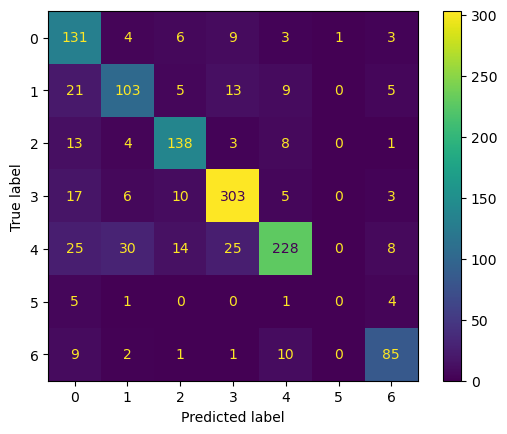

In [47]:
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier

ct = ColumnTransformer(
    transformers= [
        (
            "minmax",
            MinMaxScaler(),
            [str(i) for i in range(300)], #applied to all columns with the embeddings
        ),
        (
            "scaling", # --> name of the transformation
            StandardScaler(), # --> main function to apply
            ["text_length"], #-->columns to apply it to (we can give more than one column at once!)
        )
    ],
    remainder="passthrough", #--> what to do with the non-transformed columns. passthrough=keep them
    verbose_feature_names_out=False #--> this keeps columns names simple.
)

clf_ = Pipeline(
        steps =[('scaling', ct),
              ('clf', MLPClassifier()),
      ]
    )

# let's define the parameters to try
hparameters = {'clf__hidden_layer_sizes': ((20,20),(10,10),(30,30)),
              'clf__alpha': (0.0001, 0.001,0.01),
               'clf__max_iter': (400,600,1000),
             }

clf_search = GridSearchCV(clf_, hparameters, scoring= "accuracy", cv= 5, error_score='raise')

# Fit all the possible hyper-parameters combinations using cross-validation: it may take some time
# original data
# let's also time it
t0 = tt()
_ =clf_search.fit(df_train_check.drop(columns=['petition_topic','clean_text']), y_train)
print(f'Time taken to train gridsearch: {tt()-t0:.2f} seconds.')

# Get the best estimator for further analysis of the results using the test set
best_clf = clf_search.best_estimator_

# Compute predictions and evaluation metrics using the best estimator
# original data
y_pred = best_clf.predict(df_test_check.drop(columns=['petition_topic',"clean_text"]))
print(classification_report(y_test, y_pred, target_names = petition_categories))

cm= ConfusionMatrixDisplay.from_estimator(best_clf, df_test_check.drop(columns=['petition_topic',"clean_text"]), y_test)


In [48]:
print(clf_search.best_score_, clf_search.best_params_)

0.7913768030272884 {'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (30, 30), 'clf__max_iter': 1000}


The accuracy is low compared to what was asked, so I have to modify the parameters

### Trying something different with the has_entity column by directly label encoding the value.

In [ ]:
mod_train_data['has_entity'].unique()

array(['EVENT:NO_DATE:NO_PERSON:NO_', 'EVENT:NO_DATE:YES_PERSON:NO_',
       'EVENT:NO_DATE:NO_PERSON:YES_', 'EVENT:NO_DATE:YES_PERSON:YES_',
       'EVENT:YES_DATE:YES_PERSON:NO_', 'EVENT:YES_DATE:YES_PERSON:YES_',
       'data missing', 'EVENT:YES_DATE:NO_PERSON:YES_',
       'EVENT:YES_DATE:NO_PERSON:NO_'], dtype=object)

In [ ]:
df_train_new_check = df_train_new.copy()
df_test_new_check = df_test_new.copy()

In [ ]:
df_train_new_check.drop(columns=["has_date","has_event","has_person"])
df_test_new_check.drop(columns=["has_date","has_event","has_person"])

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,text_length,petition_topic
5240,-0.756906,0.199952,-0.168911,-0.045260,-0.255803,0.118857,-0.130520,-0.006530,-0.125018,1.150565,...,0.048483,-0.103564,-0.152283,0.259576,-0.128978,-0.145095,-0.037680,0.060156,750,3
2672,-0.694980,0.116656,-0.061749,-0.028529,-0.051513,-0.063258,0.071294,0.004283,0.016378,1.991675,...,-0.069255,-0.007378,-0.018020,0.088601,0.014388,-0.141721,0.133277,0.018061,789,0
6071,-0.697740,0.172371,0.102460,-0.051618,-0.189875,0.002202,0.009835,0.036387,-0.003723,1.541139,...,0.023094,0.042788,-0.050962,0.174501,-0.048599,-0.094152,0.025717,0.083867,776,6
2405,-0.699950,0.142938,-0.127958,-0.079332,-0.096946,0.137893,-0.042101,0.010298,-0.033583,1.513242,...,-0.101476,-0.059601,-0.109659,0.052665,-0.140957,-0.224622,0.210164,0.022017,798,4
8685,-0.706644,0.172924,0.010476,-0.061168,-0.156598,-0.039688,0.080820,-0.012794,0.023194,1.784954,...,0.131235,0.090055,0.022559,0.066213,-0.067401,-0.103203,0.110865,-0.038141,654,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6664,-0.703123,0.089415,-0.115443,-0.021166,-0.159254,-0.063038,0.014358,-0.075411,0.130585,1.530336,...,-0.235489,-0.076201,0.010019,0.091830,0.003160,-0.047658,0.026715,0.139009,403,4
8260,-0.682688,0.117404,0.005274,-0.033516,-0.074261,-0.073758,0.025916,0.006546,0.063762,1.748267,...,-0.047850,-0.015764,0.029244,0.005267,0.005856,-0.098518,0.116981,0.062416,870,3
4351,-0.721015,-0.048350,0.464835,0.078228,-0.147376,0.022166,-0.031392,0.361409,0.273816,2.083250,...,-0.046126,0.011173,-0.323715,0.079539,0.152581,-0.175760,0.117640,-0.217992,107,6
5191,-0.701456,0.239346,0.060322,-0.090363,-0.194062,-0.071167,-0.001795,0.037609,0.130520,1.939825,...,0.079053,-0.031027,0.032097,0.053145,-0.056209,-0.132920,0.001803,-0.142482,631,4


In [ ]:
# df_train_new_check["has_entity"] = mod_train_data["has_entity"]
# df_test_new_check["has_entity"] = mod_test_data["has_entity"]

In [ ]:
lblEncoder_A = LabelEncoder()

lblEncoder_A = lblEncoder_A.fit(df_train_new_check["has_entity"]) # we can fit and transform all at once
df_train_new_check["has_entity"] = lblEncoder_A.transform(df_train_new_check["has_entity"])

print(df_train_new_check["has_entity"])
print()

lblEncoder_C = LabelEncoder()

lblEncoder_C = lblEncoder_C.fit(df_test_new_check["has_entity"]) # we can fit and transform all at once
df_test_new_check["has_entity"] = lblEncoder_C.transform(df_test_new_check["has_entity"])

print(df_test_new_check["has_entity"])

5255    0
5572    0
2422    0
3342    2
5224    0
       ..
4929    2
1701    2
5517    3
1451    0
332     0
Name: has_entity, Length: 6790, dtype: int64

5240    0
2672    0
6071    0
2405    0
8685    3
       ..
6664    2
8260    2
4351    0
5191    1
7300    0
Name: has_entity, Length: 1697, dtype: int32


In [ ]:
df_train_new_check["has_entity"].value_counts()

has_entity
0    3163
2    2285
1     644
3     554
6      59
4      43
8      21
7      14
5       7
Name: count, dtype: int64

In [ ]:
df_test_new_check["has_entity"].value_counts()

has_entity
0    826
2    564
3    140
1    134
6     13
7      8
4      8
8      3
5      1
Name: count, dtype: int64

### After labeling the has-entity labels, testing the classifer again

Time taken to train gridsearch: 9745.64 seconds.
                                precision    recall  f1-score   support

environment and animal welfare       0.75      0.77      0.76       195
        health and social care       0.76      0.78      0.77       247
   economy, labour and welfare       0.87      0.77      0.81       217
                     education       0.89      0.82      0.85       462
      culture, sport and media       0.77      0.84      0.80       430
  uk government and devolution       0.71      0.50      0.59        10
                        london       0.80      0.90      0.84       136

                      accuracy                           0.81      1697
                     macro avg       0.79      0.77      0.78      1697
                  weighted avg       0.81      0.81      0.81      1697



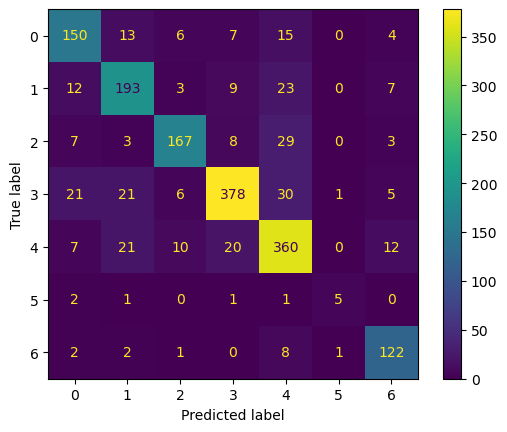

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

bal_clf_ = ImbPipeline(
        steps =[
            ('resampling', RandomOverSampler(random_state=0)),
            ('scaling', ct),
            ('clf', MLPClassifier()),
      ]
    )

# let's define the parameters to try
bal_hparameters = {'clf__hidden_layer_sizes': ((200,20), (200,)),
                'clf__alpha': (0.00001,0.0001, 0.001),
               'clf__max_iter': [(600)],
             }

clf_search = GridSearchCV(bal_clf_, bal_hparameters, scoring= "accuracy", cv= 5)

t0 = tt()
_ =clf_search.fit(df_train_new_check.drop(columns=['petition_topic']), y_train)
print(f'Time taken to train gridsearch: {tt()-t0:.2f} seconds.')

# Get the best estimator for further analysis of the results using the test set
best_clf = clf_search.best_estimator_

# Compute predictions and evaluation metrics using the best estimator
# original data
y_pred = best_clf.predict(df_test_new_check.drop(columns=['petition_topic']))
print(classification_report(y_test, y_pred, target_names = petition_categories))

cm= ConfusionMatrixDisplay.from_estimator(best_clf, df_test_new_check.drop(columns=['petition_topic']), y_test)

In [ ]:
print(accuracy_score(y_test,y_pred))

0.8102533883323512


Scores are again not that great

## Try Logistic Regression

In [49]:
import warnings
warnings.simplefilter("ignore")

# extract the target
y_train = df_train_check["petition_topic"]
y_test = df_test_check["petition_topic"]

petition_categories = ["environment and animal welfare","health and social care","economy, labour and welfare","education","culture, sport and media","uk government and devolution","london"]

In [48]:
df_train_check.head()

,has_entity,petition_topic,clean_text,text_length
4240,1,6,find the time to take the kept animals bill th...,649
2212,0,3,require meat sellers to display how all meat w...,836
8724,6,3,only allow sale and use of fireworks on 5 nove...,552
8236,2,4,make covid-19 booster vaccines available to vu...,468
6814,2,4,exempt children under 10 from the rule of six....,412


#### creating a separate table to remove has_entity and check the model performance

In [59]:
df_train_check_without_entity = df_train_check.copy()
df_test_check_without_entity = df_test_check.copy()

In [61]:
df_train_check_without_entity.drop(columns =["has_entity"])
df_test_check_without_entity.drop(columns =["has_entity"])

,petition_topic,clean_text,text_length
2112,3,give councils powers to tax takeaway packaging...,676
8343,1,change the way universal credit works for 4 we...,719
8407,3,introduce mandatory licensing and regulation o...,452
5899,0,hold a referendum on whether to end annual clo...,764
5580,2,give students that will take gcse's and a-leve...,273
...,...,...,...
534,4,require icon identifying alcohol as an ingredi...,586
3130,5,amend the 1999 gla act to remove the mayor's p...,845
868,2,all nurses and doctors should have there stude...,307
204,3,require products containing plastic to be clea...,688


### Trying logistic Regression without the has_entity column

In [62]:
from sklearn.compose import ColumnTransformer

mod_ct_log = ColumnTransformer(
    transformers= [

        (
            'vectorizer',
             TfidfVectorizer(lowercase=True),
             'clean_text',
        ),
        (
            "scaler", # --> name of the transformation
            StandardScaler(), # --> main function to apply
            ["text_length"], #-->columns to apply it to (we can give more than one column at once!)
        )
    ],
    remainder="passthrough", #--> what to do with the non-transformed columns. passthrough=keep them
    verbose_feature_names_out=False #--> this keeps columns names simple.
)

mod_clf_ = Pipeline(
        steps =[
            ('ct', mod_ct_log),
            ('clf', LogisticRegression( multi_class='multinomial', max_iter=1000)),
      ]
    )

mod_clf_.get_params()

{'memory': None,
 'steps': [('ct', ColumnTransformer(remainder='passthrough',
                     transformers=[('vectorizer', TfidfVectorizer(), 'clean_text'),
                                   ('scaler', StandardScaler(), ['text_length'])],
                     verbose_feature_names_out=False)),
  ('clf', LogisticRegression(max_iter=1000, multi_class='multinomial'))],
 'transform_input': None,
 'verbose': False,
 'ct': ColumnTransformer(remainder='passthrough',
                   transformers=[('vectorizer', TfidfVectorizer(), 'clean_text'),
                                 ('scaler', StandardScaler(), ['text_length'])],
                   verbose_feature_names_out=False),
 'clf': LogisticRegression(max_iter=1000, multi_class='multinomial'),
 'ct__force_int_remainder_cols': True,
 'ct__n_jobs': None,
 'ct__remainder': 'passthrough',
 'ct__sparse_threshold': 0.3,
 'ct__transformer_weights': None,
 'ct__transformers': [('vectorizer', TfidfVectorizer(), 'clean_text'),
  ('scaler', Sta

In [63]:
# Test TfidfVectorizer alone
tfidf = TfidfVectorizer(lowercase=True)
tfidf_output = tfidf.fit_transform(df_train_check_without_entity['clean_text'])
print("TF-IDF shape:", tfidf_output.shape)  # Should be (5769, vocab_size)

# # Test StandardScaler on embeddings
# scaler = StandardScaler()
# embed_output = scaler.fit_transform(df_train_new[[str(i) for i in range(300)]])
# print("Embeddings shape:", embed_output.shape)  # Should be (5769, 300)

TF-IDF shape: (7214, 18698)


Time taken to train gridsearch: 8372.78 seconds.

                                precision    recall  f1-score   support

environment and animal welfare       0.87      0.88      0.88       144
        health and social care       0.79      0.82      0.81       169
   economy, labour and welfare       0.86      0.89      0.88       178
                     education       0.92      0.90      0.91       366
      culture, sport and media       0.88      0.85      0.86       299
  uk government and devolution       0.70      1.00      0.82         7
                        london       0.87      0.90      0.88       110

                      accuracy                           0.87      1273
                     macro avg       0.84      0.89      0.86      1273
                  weighted avg       0.87      0.87      0.87      1273

0.8702526809322926 {'clf__C': 1.0, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'saga', 'ct__vectorizer__max_df': 1.0, 'ct__vector

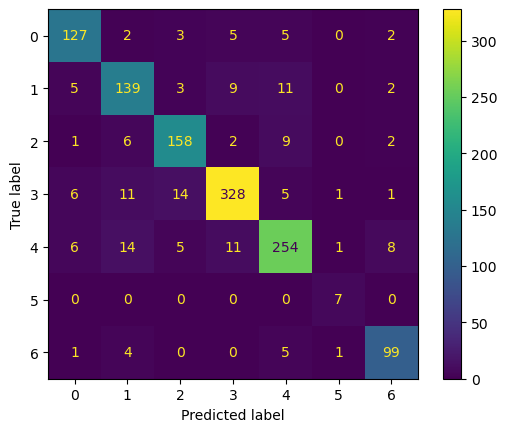

In [64]:
# let's define the parameters to try
mod_hparameters = {
              'ct__vectorizer__ngram_range': [(1, 1),(1, 2)],
              'ct__vectorizer__min_df': [1,2],
              'ct__vectorizer__max_df': [0.5,1.0],
              'clf__C': [(1.0)],
              'clf__class_weight': ('balanced',None),
              'clf__penalty': ('l2','l1'),
              'clf__solver': ['saga'],
             }

mod_clf_search = GridSearchCV(mod_clf_, mod_hparameters, scoring= "accuracy", cv= 5,error_score='raise')

t0 = tt()
_ =mod_clf_search.fit(df_train_check_without_entity.drop(columns=['petition_topic']), y_train)
print(f'Time taken to train gridsearch: {tt()-t0:.2f} seconds.')
print()
# Get the best estimator for further analysis of the results using the test set
mod_best_clf = mod_clf_search.best_estimator_

# Compute predictions and evaluation metrics using the best estimator
# original data
y_pred = mod_best_clf.predict(df_test_check_without_entity.drop(columns=['petition_topic']))
print(classification_report(y_test, y_pred, target_names = petition_categories))

cm= ConfusionMatrixDisplay.from_estimator(best_clf, df_test_check_without_entity.drop(columns=['petition_topic']), y_test)

print(clf_search.best_score_, clf_search.best_params_)
print()
print(accuracy_score(y_test,y_pred))

Above model appears to be the best outcome I have had so far, but the precision for uk_government topic is not meeting the requirement and the model runtime is taking a long time because of the hyperparameters I have provided which does not help. so i will try to minimize the number of hyper parameters used and try to utilize the SGDClassifier in the form of a Logistic Reg model to check next.

Also, excuse the redoing of the parameters as I had run the outcomes on multiple pynb files to test and I got confused with the parameters so I have redefined them again 

In [65]:
data = pd.read_csv("comp1804_coursework_dataset_24-25.csv")
data.head()

,petition_ID,has_entity,relevant_department,deviation_across_regions,petition_status,petition_topic,petition_importance,petition_text
0,607158,EVENT:NO_DATE:NO_PERSON:NO_,Department for Education,0.000137,unsuccessful,education,not_important,Ban school uniforms in English schools. I want...
1,590629,EVENT:NO_DATE:YES_PERSON:NO_,Department of Health and Social Care,0.002133,unsuccessful,uk government and devolution,important,Lock NHS pay rises to increases in pay for MPs...
2,652724,EVENT:NO_DATE:NO_PERSON:NO_,Department of Health and Social Care,0.000272,unsuccessful,health and social care,important,Require dose counters on SABA metered dose inh...
3,629281,EVENT:NO_DATE:NO_PERSON:NO_,HM Treasury,0.000083,unsuccessful,"economy, labour and welfare",not_important,Remove the 20% VAT on private dementia day car...
4,301747,EVENT:NO_DATE:NO_PERSON:NO_,NaN,NaN,rejected,"culture, sport and media",not_important,Make bank holidays a holiday. Make bank holida...


In [66]:
duplicates_rows = data.duplicated()
# The result is True for rows that are a duplicate, False for rows that are not a duplicate

print(f'There are {duplicates_rows.sum()} duplicates rows.')

# We have no duplicates here,
# but if we had them, to remove them we'd only keep the rows that are NOT duplicates
data = data[~duplicates_rows]

There are 378 duplicates rows.


In [67]:
print(f'Original dataset length: {len(data)}')

Original dataset length: 8520


In [68]:
data = data.dropna(subset=["petition_topic","petition_text"])

In [69]:
print(f'After droping na, dataset length: {len(data)}')

After droping na, dataset length: 8487


In [70]:
data.isnull().sum()

petition_ID                    0
has_entity                     0
relevant_department         1789
deviation_across_regions    1571
petition_status                0
petition_topic                 0
petition_importance         8467
petition_text                  0
dtype: int64

In [71]:
X= data.drop(columns=['petition_topic'])
Y= data["petition_topic"]

In [72]:
Y = pd.DataFrame(Y)

In [73]:
X.head()

,petition_ID,has_entity,relevant_department,deviation_across_regions,petition_status,petition_importance,petition_text
0,607158,EVENT:NO_DATE:NO_PERSON:NO_,Department for Education,0.000137,unsuccessful,not_important,Ban school uniforms in English schools. I want...
1,590629,EVENT:NO_DATE:YES_PERSON:NO_,Department of Health and Social Care,0.002133,unsuccessful,important,Lock NHS pay rises to increases in pay for MPs...
2,652724,EVENT:NO_DATE:NO_PERSON:NO_,Department of Health and Social Care,0.000272,unsuccessful,important,Require dose counters on SABA metered dose inh...
3,629281,EVENT:NO_DATE:NO_PERSON:NO_,HM Treasury,0.000083,unsuccessful,not_important,Remove the 20% VAT on private dementia day car...
4,301747,EVENT:NO_DATE:NO_PERSON:NO_,NaN,NaN,rejected,not_important,Make bank holidays a holiday. Make bank holida...


In [74]:
Y[Y['petition_topic'] == True]

,petition_topic


In [75]:
Y.loc[Y.petition_topic=='Health And Social Care','petition_topic'] = 'health and social care'

Y.loc[Y.petition_topic=='Environment And Animal Welfare','petition_topic'] = 'environment and animal welfare'

Y.loc[Y.petition_topic=='Economy, Labour And Welfare','petition_topic'] = 'economy, labour and welfare'

Y.loc[Y.petition_topic=='Education','petition_topic'] = 'education'

Y.loc[Y.petition_topic=='Culture, Sport And Media','petition_topic'] = 'culture, sport and media'

Y.loc[Y.petition_topic=='Uk Government And Devolution','petition_topic'] = 'uk government and devolution'

Y.loc[Y.petition_topic=='London','petition_topic'] = 'london'

In [76]:
Y.petition_topic.value_counts()

petition_topic
environment and animal welfare    2297
health and social care            2046
economy, labour and welfare       1190
education                         1158
culture, sport and media          1016
uk government and devolution       720
london                              60
Name: count, dtype: int64

In [77]:
x_train,x_test,y_train, y_test = train_test_split(X, Y, test_size= 0.2, stratify = Y, shuffle=True)

In [78]:
x_train.shape

(6789, 7)

In [79]:
x_test.shape

(1698, 7)

In [80]:
y_train.shape

(6789, 1)

In [82]:
y_test.shape

(1698, 1)

In [83]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6789 entries, 1490 to 7566
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   petition_ID               6789 non-null   int64  
 1   has_entity                6789 non-null   object 
 2   relevant_department       5340 non-null   object 
 3   deviation_across_regions  5517 non-null   float64
 4   petition_status           6789 non-null   object 
 5   petition_importance       14 non-null     object 
 6   petition_text             6789 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 424.3+ KB


In [85]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1698 entries, 3872 to 1592
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   petition_ID               1698 non-null   int64  
 1   has_entity                1698 non-null   object 
 2   relevant_department       1358 non-null   object 
 3   deviation_across_regions  1399 non-null   float64
 4   petition_status           1698 non-null   object 
 5   petition_importance       6 non-null      object 
 6   petition_text             1698 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 106.1+ KB


In [86]:
x_train.isna().sum()

petition_ID                    0
has_entity                     0
relevant_department         1449
deviation_across_regions    1272
petition_status                0
petition_importance         6775
petition_text                  0
dtype: int64

In [87]:
x_train = x_train.drop(columns=["petition_ID","relevant_department","deviation_across_regions","petition_importance","petition_status"])
x_test= x_test.drop(columns=["petition_ID","relevant_department","deviation_across_regions","petition_importance","petition_status"])

In [88]:
print('How many texts have the newline character "\\n"?')

print("train: ", x_train['petition_text'].str.contains("\n").sum())
print("test: ",x_test['petition_text'].str.contains("\n").sum())

How many texts have the newline character "\n"?
train:  2614
test:  624


In [89]:
from cleantext import clean

def clean_text(x):
  """ Define standard cleaning procedure """
  return clean(x,
    fix_unicode=True,               # fix various unicode errors
    lower=True,                     # change all text to lowercase
    no_line_breaks=True,           # this removes occurrences of the newline character "\n"
    no_punct=False,                 # let's NOT remove punctuations for the time being
    no_urls=True,                  # replace all URLs with a special token (below)
    replace_with_url="",          # we decide to replace urls with nothing
    no_emails=True,                # replace all email addresses with a special token
    replace_with_email="",        # we decide to replace emails with nothing
    no_phone_numbers=True,         # replace all phone numbers with a special token
    replace_with_phone_number="",   # we decide to replace phone numbers with nothing
    lang="en"                       # set to 'de' for German special handling
    )


In [90]:
x_train['clean_text']= x_train['petition_text'].apply(clean_text)
x_test['clean_text']= x_test['petition_text'].apply(clean_text)

In [91]:
x_train['text_length'] = x_train['clean_text'].apply(len)
x_test['text_length'] = x_test['clean_text'].apply(len)

In [92]:
x_train.head()

,has_entity,petition_text,clean_text,text_length
1490,EVENT:NO_DATE:NO_PERSON:NO_,Prohibit latex gloves. To ban the use latex gl...,prohibit latex gloves. to ban the use latex gl...,791
8309,EVENT:NO_DATE:YES_PERSON:NO_,Require supermarkets to sell fuel at cost pric...,require supermarkets to sell fuel at cost pric...,399
6328,EVENT:NO_DATE:NO_PERSON:NO_,Ensure the income threshold for Pension Credit...,ensure the income threshold for pension credit...,776
5297,EVENT:NO_DATE:NO_PERSON:NO_,Exempt urban businesses from dog day care spac...,exempt urban businesses from dog day care spac...,883
7004,EVENT:NO_DATE:NO_PERSON:NO_,Remove VAT and other taxes off all baby and ch...,remove vat and other taxes off all baby and ch...,498


In [93]:
x_test.head()

,has_entity,petition_text,clean_text,text_length
3872,EVENT:NO_DATE:NO_PERSON:NO_,"Protect the clinically vulnerable, including d...","protect the clinically vulnerable, including d...",757
8445,EVENT:NO_DATE:NO_PERSON:NO_,Self employed worker's ask for bailout to surv...,self employed worker's ask for bailout to surv...,645
5000,EVENT:NO_DATE:NO_PERSON:YES_,Allow overnight fishing during lockdown.. Allo...,allow overnight fishing during lockdown.. allo...,643
6900,EVENT:NO_DATE:YES_PERSON:NO_,Habitat Protection - Public inquiry and reform...,habitat protection - public inquiry and reform...,742
696,EVENT:NO_DATE:YES_PERSON:NO_,Stop all gambling adverts on television and ra...,stop all gambling adverts on television and ra...,561


In [94]:
import string
EXTRA_PUNCT = string.punctuation

# import Spacy
import spacy
# create the Spacy pipeline
nlp = spacy.load('en_core_web_sm')

def preprocess_text_with_spacy(text_):
  """
  This function takes a Spacy doc and returns the list of its lemmas,
  after removing stop words and punctuations
  """
  # process document with Spacy
  # Note that if we were to first run all the documents through Spacy
  # (remember the nlp.pipe()) it would be faster because Spacy processes
  # multiple documents in parallel. However we'd have to create an intermediate
  # variable or column where to store all the Spacy objects, then process them
  # one by one and add the results to our dataframe.
  doc_ = nlp(text_)
  # here we take the lemmas, and now we also want to but only keep those that are NOT stop words, only digits, or punctuation.
  lemmas_ = [token.lemma_ for token in doc_ if not (token.is_stop or token.is_punct or token.is_digit)]
  # remember when I said punctuation is tricky?
  # Spacy misses some characters that we want to remove that can also be considered punctuation (= and +)
  # Here is where we remove them
  return [lemma for lemma in lemmas_ if lemma not in EXTRA_PUNCT]

In [95]:
from time import time as tt
t0 = tt()
x_train['tokenized_text'] = x_train['clean_text'].apply(preprocess_text_with_spacy)
print(f'Time elapsed is {(tt()-t0):.2f} seconds')

Time elapsed is 179.37 seconds


In [96]:
# tokenize test data (start from the cleaned text!)
t0 = tt()
x_test['tokenized_text'] = x_test['clean_text'].apply(preprocess_text_with_spacy)
print(f'Time elapsed is {(tt()-t0):.2f} seconds')


Time elapsed is 38.90 seconds


In [98]:
from sklearn.preprocessing import LabelEncoder

lblEncoder_X = LabelEncoder()

lblEncoder_X = lblEncoder_X.fit(y_train['petition_topic']) # we can fit and transform all at once
y_train['petition_topic'] = lblEncoder_X.transform(y_train['petition_topic'])

print(y_train['petition_topic'])
print()
lblEncoder_Y = LabelEncoder()

lblEncoder_Y = lblEncoder_Y.fit(y_test['petition_topic']) # we can fit and transform all at once
y_test['petition_topic'] = lblEncoder_Y.transform(y_test['petition_topic'])

print(y_test['petition_topic'])


1490    4
8309    3
6328    1
5297    3
7004    1
       ..
7781    1
5682    4
8335    3
8390    0
7566    2
Name: petition_topic, Length: 6789, dtype: int32

3872    4
8445    1
5000    3
6900    3
696     0
       ..
4268    0
7898    3
2887    3
8053    1
1592    4
Name: petition_topic, Length: 1698, dtype: int32


In [99]:
x_train.head()

,has_entity,petition_text,clean_text,text_length,tokenized_text
1490,EVENT:NO_DATE:NO_PERSON:NO_,Prohibit latex gloves. To ban the use latex gl...,prohibit latex gloves. to ban the use latex gl...,791,"[prohibit, latex, glove, ban, use, latex, glov..."
8309,EVENT:NO_DATE:YES_PERSON:NO_,Require supermarkets to sell fuel at cost pric...,require supermarkets to sell fuel at cost pric...,399,"[require, supermarket, sell, fuel, cost, price..."
6328,EVENT:NO_DATE:NO_PERSON:NO_,Ensure the income threshold for Pension Credit...,ensure the income threshold for pension credit...,776,"[ensure, income, threshold, pension, credit, h..."
5297,EVENT:NO_DATE:NO_PERSON:NO_,Exempt urban businesses from dog day care spac...,exempt urban businesses from dog day care spac...,883,"[exempt, urban, business, dog, day, care, spac..."
7004,EVENT:NO_DATE:NO_PERSON:NO_,Remove VAT and other taxes off all baby and ch...,remove vat and other taxes off all baby and ch...,498,"[remove, vat, taxis, baby, child, safety, prod..."


In [102]:
x_train=x_train.drop(columns=["has_entity"])
x_test=x_test.drop(columns=["has_entity"])

In [103]:
import warnings
warnings.simplefilter("ignore")

petition_categories = ["environment and animal welfare","health and social care","economy, labour and welfare","education","culture, sport and media","uk government and devolution","london"]

In [104]:
# create custom class to add to the pipeline
from sklearn.base import TransformerMixin
class DenseTransformer(TransformerMixin):
    ''' Pipeline step to transform a sparse matrix into a dense one '''
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()
    

In [119]:
clf_ = Pipeline(
        steps =[
                ('vectorizer', TfidfVectorizer(lowercase=False, tokenizer=lambda x: x, preprocessor=lambda x: x)),
                ('to_dense', DenseTransformer()), #If you want, you can see the error message you can get if you remove this step - you'll also have to use a different classifier, like RandomForestClassifier
              ('classifier', SGDClassifier()),
      ]
    )

clf_.get_params()

{'memory': None,
 'steps': [('vectorizer', TfidfVectorizer(lowercase=False,
                   preprocessor=<function <lambda> at 0x0000027055629940>,
                   tokenizer=<function <lambda> at 0x000002705562AFC0>)),
  ('to_dense', <__main__.DenseTransformer at 0x270442804a0>),
  ('classifier', SGDClassifier())],
 'transform_input': None,
 'verbose': False,
 'vectorizer': TfidfVectorizer(lowercase=False,
                 preprocessor=<function <lambda> at 0x0000027055629940>,
                 tokenizer=<function <lambda> at 0x000002705562AFC0>),
 'to_dense': <__main__.DenseTransformer at 0x270442804a0>,
 'classifier': SGDClassifier(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.float64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': False,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_r

In [120]:
# let's define the parameters to try
hparameters = {
              'vectorizer__ngram_range': [(1,1),(1, 2)],
              'vectorizer__max_features': [2000,25000],
              'classifier__penalty': [('l2')],
              'classifier__alpha': [0.0001],
             }

clf_search = GridSearchCV(clf_, hparameters, scoring= "accuracy")



In [121]:
t0 = tt()
_ =clf_search.fit(x_train.tokenized_text, y_train)
print(f'Time taken to train gridsearch: {tt()-t0:.2f} seconds.')
print()
# Get the best estimator for further analysis of the results using the test set
best_clf = clf_search.best_estimator_



Time taken to train gridsearch: 294.13 seconds.



                                precision    recall  f1-score   support

environment and animal welfare       0.90      0.88      0.89       203
        health and social care       0.85      0.91      0.88       238
   economy, labour and welfare       0.91      0.86      0.88       232
                     education       0.95      0.93      0.94       460
      culture, sport and media       0.87      0.91      0.89       409
  uk government and devolution       1.00      0.42      0.59        12
                        london       0.83      0.82      0.83       144

                      accuracy                           0.90      1698
                     macro avg       0.90      0.82      0.84      1698
                  weighted avg       0.90      0.90      0.90      1698

0.8932090518481054 {'classifier__alpha': 0.0001, 'classifier__penalty': 'l2', 'vectorizer__max_features': 25000, 'vectorizer__ngram_range': (1, 2)}

0.8957597173144877


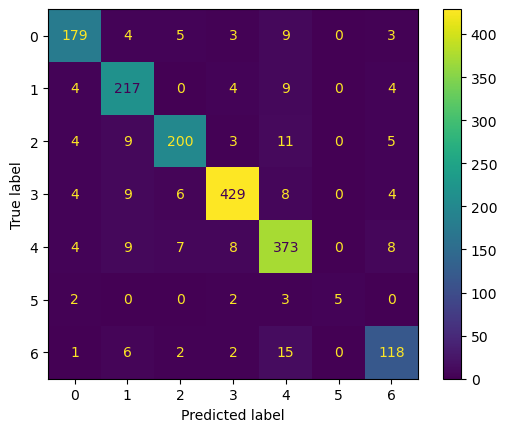

In [123]:
# Compute predictions and evaluation metrics using the best estimator
# original data
y_pred = best_clf.predict(x_test.tokenized_text)
print(classification_report(y_test, y_pred, target_names = petition_categories))

cm= ConfusionMatrixDisplay.from_estimator(best_clf, x_test.tokenized_text, y_test)

print(clf_search.best_score_, clf_search.best_params_)
print()
print(accuracy_score(y_test,y_pred))

In [134]:
from sklearn.metrics import f1_score, precision_score,  recall_score

In [136]:
f1_score(y_test,y_pred,average='weighted')

0.8952531199733798

In [137]:
precision_score(y_test,y_pred,average='weighted')

0.8971875958872196

In [138]:
recall_score(y_test,y_pred,average='weighted')

0.8957597173144877

# Task 2

Task obj: However, they do not have any labels for this task outside of the first few rows of the dataset. So, they want you to build a prototype by first labelling a subset of the data (they give an optional suggestion of 80 data points), and then build a machine learning algorithm to predict these labels from the text and any other feature that may be relevant

In [85]:
updated_data = pd.read_csv("updated_comp1804_coursework_dataset_24-25.csv")

In [86]:
updated_data

,petition_ID,has_entity,relevant_department,deviation_across_regions,petition_status,petition_topic,petition_importance,petition_text
0,607158,EVENT:NO_DATE:NO_PERSON:NO_,Department for Education,0.000137,unsuccessful,education,not_important,Ban school uniforms in English schools. I want...
1,590629,EVENT:NO_DATE:YES_PERSON:NO_,Department of Health and Social Care,0.002133,unsuccessful,uk government and devolution,important,Lock NHS pay rises to increases in pay for MPs...
2,652724,EVENT:NO_DATE:NO_PERSON:NO_,Department of Health and Social Care,0.000272,unsuccessful,health and social care,important,Require dose counters on SABA metered dose inh...
3,629281,EVENT:NO_DATE:NO_PERSON:NO_,HM Treasury,0.000083,unsuccessful,"economy, labour and welfare",not_important,Remove the 20% VAT on private dementia day car...
4,301747,EVENT:NO_DATE:NO_PERSON:NO_,NaN,NaN,rejected,"culture, sport and media",not_important,Make bank holidays a holiday. Make bank holida...
...,...,...,...,...,...,...,...,...
8893,569251,EVENT:NO_DATE:NO_PERSON:YES_,Department of Health and Social Care,0.000109,unsuccessful,health and social care,NaN,Fund free meals for NHS frontline workers whil...
8894,616956,EVENT:NO_DATE:YES_PERSON:YES_,HM Treasury,0.000051,unsuccessful,environment and animal welfare,NaN,Cap profit fuel forecourt operators can make o...
8895,302075,data missing,NaN,NaN,rejected,"culture, sport and media",NaN,Coronavirus. Re-introduce free TV license for ...
8896,326309,EVENT:NO_DATE:NO_PERSON:NO_,"Department for Digital, Culture, Media and Sport",0.000077,unsuccessful,"culture, sport and media",NaN,Restrict the share size of individuals and com...


#### perform cleaning and encoding

In [87]:
duplicates_rows = updated_data.duplicated()
# The result is True for rows that are a duplicate, False for rows that are not a duplicate

print(f'There are {duplicates_rows.sum()} duplicates rows.')

updated_data = updated_data[~duplicates_rows]

There are 374 duplicates rows.


In [88]:
updated_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8524 entries, 0 to 8897
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   petition_ID               8524 non-null   int64  
 1   has_entity                8524 non-null   object 
 2   relevant_department       6728 non-null   object 
 3   deviation_across_regions  6947 non-null   float64
 4   petition_status           8524 non-null   object 
 5   petition_topic            8493 non-null   object 
 6   petition_importance       100 non-null    object 
 7   petition_text             8522 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 599.3+ KB


In [89]:
from sklearn.impute import SimpleImputer

imptr= SimpleImputer(missing_values= np.nan, strategy='mean')

In [103]:
import warnings
warnings.simplefilter("ignore")

In [90]:
updated_data["deviation_across_regions"] = imptr.fit_transform(updated_data[["deviation_across_regions"]])

C:\Users\Ganesh\AppData\Local\Temp\ipykernel_2352\561240359.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  updated_data["deviation_across_regions"] = imptr.fit_transform(updated_data[["deviation_across_regions"]])


In [91]:
updated_data["relevant_department"] = updated_data["relevant_department"].fillna("UNKNOWN")

C:\Users\Ganesh\AppData\Local\Temp\ipykernel_2352\2813636530.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  updated_data["relevant_department"] = updated_data["relevant_department"].fillna("UNKNOWN")


In [92]:
updated_data = updated_data.drop(columns=["petition_ID","petition_status","petition_topic"])

Lets utilize has_entity in this section as it might have an effect on the overall which can be checked

In [93]:
def ent_conv_func(df):
    df['has_entity'] = df['has_entity'].fillna('EVENT:NO_DATE:NO_PERSON:NO_')
    df['has_entity'] = df['has_entity'].replace('data missing', 'EVENT:NO_DATE:NO_PERSON:NO_')
    df['has_event'] = df['has_entity'].apply(lambda x: 1 if 'EVENT:YES' in x else 0)
    df['has_date'] = df['has_entity'].apply(lambda x: 1 if 'YES_DATE' in x else 0)
    df['has_person'] = df['has_entity'].apply(lambda x: 1 if 'YES_PERSON' in x else 0)
    df.drop(columns=['has_entity'], inplace=True)
    return df

In [94]:
updated_data = ent_conv_func(updated_data)

In [95]:
from cleantext import clean

def clean_text(x):
  """ Define standard cleaning procedure """
  return clean(x,
    fix_unicode=True,               # fix various unicode errors
    lower=True,                     # change all text to lowercase
    no_line_breaks=True,           # this removes occurrences of the newline character "\n"
    no_punct=False,                 # let's NOT remove punctuations for the time being
    no_urls=True,                  # replace all URLs with a special token (below)
    replace_with_url="",          # we decide to replace urls with nothing
    no_emails=True,                # replace all email addresses with a special token
    replace_with_email="",        # we decide to replace emails with nothing
    no_phone_numbers=True,         # replace all phone numbers with a special token
    replace_with_phone_number="",   # we decide to replace phone numbers with nothing
    lang="en"                       # set to 'de' for German special handling
    )

In [96]:
updated_data['petition_text']= updated_data['petition_text'].apply(clean_text)

In [97]:
import string
EXTRA_PUNCT = string.punctuation

# import Spacy
import spacy
# create the Spacy pipeline
nlp = spacy.load('en_core_web_sm')

def preprocess_text_with_spacy(text_):
  """
  This function takes a Spacy doc and returns the list of its lemmas,
  after removing stop words and punctuations
  """
  # process document with Spacy
  # Note that if we were to first run all the documents through Spacy
  # (remember the nlp.pipe()) it would be faster because Spacy processes
  # multiple documents in parallel. However we'd have to create an intermediate
  # variable or column where to store all the Spacy objects, then process them
  # one by one and add the results to our dataframe.
  doc_ = nlp(text_)
  # here we take the lemmas, and now we also want to but only keep those that are NOT stop words, only digits, or punctuation.
  lemmas_ = [token.lemma_ for token in doc_ if not (token.is_stop or token.is_punct or token.is_digit)]
  # remember when I said punctuation is tricky?
  # Spacy misses some characters that we want to remove that can also be considered punctuation (= and +)
  # Here is where we remove them
  return [lemma for lemma in lemmas_ if lemma not in EXTRA_PUNCT]

In [98]:
from time import time as tt
t0 = tt()
updated_data['petition_text'] = updated_data['petition_text'].apply(preprocess_text_with_spacy)
print(f'Time elapsed is {(tt()-t0):.2f} seconds')

Time elapsed is 195.48 seconds


### Lets store only the labelled data into labelled for our Supervised model

In [133]:
labelled_data = updated_data[updated_data['petition_importance'].notna()].copy()

In [120]:
labelled_data

,relevant_department,deviation_across_regions,petition_importance,petition_text,has_event,has_date,has_person
0,Department for Education,0.000137,not_important,"[ban, school, uniform, english, school, want, ...",0,0,0
1,Department of Health and Social Care,0.002133,important,"[lock, nhs, pay, rise, increase, pay, mp, back...",0,0,1
2,Department of Health and Social Care,0.000272,important,"[require, dose, counter, saba, meter, dose, in...",0,0,0
3,HM Treasury,0.000083,not_important,"[remove, vat, private, dementia, day, care, ce...",0,0,0
4,UNKNOWN,0.001095,not_important,"[bank, holiday, holiday, bank, holiday, holida...",0,0,0
...,...,...,...,...,...,...,...
95,HM Treasury,0.000014,important,"[suspend, personal, taxation, general, electio...",0,0,0
96,Department of Health and Social Care,0.027554,important,"[increase, dedicated, funding, childhood, canc...",0,0,1
97,Department for Education,0.000024,not_important,"[require, school, friday, half, day, change, t...",0,0,1
98,"Department for Environment, Food and Rural Aff...",0.000117,important,"[create, public, database, register, vet, find...",0,0,0


Lets encode the target labels

In [130]:
le = LabelEncoder()

In [131]:
le_petition= le.fit_transform(labelled_data[["petition_importance"]])

In [132]:
labelled_data["petition_importance"] =le_petition
labelled_data.head()

,relevant_department,deviation_across_regions,petition_importance,petition_text,has_event,has_date,has_person
0,Department for Education,0.000137,1,"[ban, school, uniform, english, school, want, ...",0,0,0
1,Department of Health and Social Care,0.002133,0,"[lock, nhs, pay, rise, increase, pay, mp, back...",0,0,1
2,Department of Health and Social Care,0.000272,0,"[require, dose, counter, saba, meter, dose, in...",0,0,0
3,HM Treasury,0.000083,1,"[remove, vat, private, dementia, day, care, ce...",0,0,0
4,UNKNOWN,0.001095,1,"[bank, holiday, holiday, bank, holiday, holida...",0,0,0


We want important as 1, but label encoder chooses its classes alphabetically so its reversing the values

In [134]:
labelled_data['petition_importance'] = labelled_data['petition_importance'].map({
    'important': 1,
    'not_important': 0
})

In [135]:
labelled_data

,relevant_department,deviation_across_regions,petition_importance,petition_text,has_event,has_date,has_person
0,Department for Education,0.000137,0,"[ban, school, uniform, english, school, want, ...",0,0,0
1,Department of Health and Social Care,0.002133,1,"[lock, nhs, pay, rise, increase, pay, mp, back...",0,0,1
2,Department of Health and Social Care,0.000272,1,"[require, dose, counter, saba, meter, dose, in...",0,0,0
3,HM Treasury,0.000083,0,"[remove, vat, private, dementia, day, care, ce...",0,0,0
4,UNKNOWN,0.001095,0,"[bank, holiday, holiday, bank, holiday, holida...",0,0,0
...,...,...,...,...,...,...,...
95,HM Treasury,0.000014,1,"[suspend, personal, taxation, general, electio...",0,0,0
96,Department of Health and Social Care,0.027554,1,"[increase, dedicated, funding, childhood, canc...",0,0,1
97,Department for Education,0.000024,0,"[require, school, friday, half, day, change, t...",0,0,1
98,"Department for Environment, Food and Rural Aff...",0.000117,1,"[create, public, database, register, vet, find...",0,0,0


Train and test split

In [136]:
X = labelled_data.drop(columns=['petition_importance'])
Y = labelled_data['petition_importance'] 

In [137]:
Y.value_counts()

petition_importance
1    51
0    49
Name: count, dtype: int64

its pretty balanced, regardless lets choose to stratify based on Y

In [138]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=0)

In [139]:
x_train.shape

(80, 6)

In [140]:
y_train.shape

(80,)

In [141]:
print(x_train['petition_text'].iloc[0])

['summer', 'clock', 'forwards', 'leave', 'need', 'day', 'age', 'farmer', 'work', 'powerful', 'light', 'tractor', 'people', 'use', 'torch', 'need', 'health', 'boost', 'able', 'travel', 'home', 'know', 'outside', 'people', 'good', 'health', 'reliance', 'electricity', 'evening']


 Had to google this error and it says the the CT is converting the input into a 2D DF instead of a list which the TFIDF is expecting so we have to define a flatting function similar to the dense function

In [145]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextFlattener(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): 
        return self
    def transform(self, X, y=None): 
        return X.to_numpy().ravel()


class DenseTransformer(TransformerMixin):
    ''' Pipeline step to transform a sparse matrix into a dense one '''
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

#### lets define the pipeline

In [146]:
from sklearn.compose import ColumnTransformer

ct_log = ColumnTransformer(
    transformers= [
        (
            'vectorizer',
            Pipeline(
                steps =[
                        ('to_unravel', TextFlattener()),
                        ('tfidf', TfidfVectorizer(lowercase=False, tokenizer=lambda x: x, preprocessor=lambda x: x)),
                        ('to_dense', DenseTransformer())
                       ]),
             ['petition_text']
        ),
        (
            'ohe',
             OneHotEncoder(handle_unknown='ignore'),
             ['relevant_department']
        ),             
    ],
    remainder="passthrough", 
    verbose_feature_names_out=False #--> this keeps columns names simple.
)

In [147]:
clf_ = Pipeline(
        steps =[
                ('ct', ct_log),
              ('classifier', SGDClassifier()),
      ]
    )

clf_.get_params()

{'memory': None,
 'steps': [('ct', ColumnTransformer(remainder='passthrough',
                     transformers=[('vectorizer',
                                    Pipeline(steps=[('to_unravel',
                                                     TextFlattener()),
                                                    ('tfidf',
                                                     TfidfVectorizer(lowercase=False,
                                                                     preprocessor=<function <lambda> at 0x000001B496449C60>,
                                                                     tokenizer=<function <lambda> at 0x000001B496449800>)),
                                                    ('to_dense',
                                                     <__main__.DenseTransformer object at 0x000001B49644CD70>)]),
                                    ['petition_text']),
                                   ('ohe', OneHotEncoder(handle_unknown='ignore'),
                   

In [148]:
hparameters = {
              'ct__vectorizer__tfidf__ngram_range': [(1,1),(1, 2)],
              'ct__vectorizer__tfidf__max_features': [2000,25000],
              'classifier__penalty': ['l2','l1'],
              'classifier__alpha': [0.0001],
             }

clf_search = GridSearchCV(clf_, hparameters, scoring= "accuracy",cv=5,error_score='raise')



In [162]:
t0 = tt()
_ =clf_search.fit(x_train, y_train)
print(f'Time taken to train gridsearch: {tt()-t0:.2f} seconds.')
print()
# Get the best estimator for further analysis of the results using the test set
best_clf = clf_search.best_estimator_



Time taken to train gridsearch: 1.05 seconds.



               precision    recall  f1-score   support

    Important       0.64      0.70      0.67        10
Non-Important       0.67      0.60      0.63        10

     accuracy                           0.65        20
    macro avg       0.65      0.65      0.65        20
 weighted avg       0.65      0.65      0.65        20

0.6625 {'classifier__alpha': 0.0001, 'classifier__penalty': 'l2', 'ct__vectorizer__tfidf__max_features': 2000, 'ct__vectorizer__tfidf__ngram_range': (1, 2)}

0.65


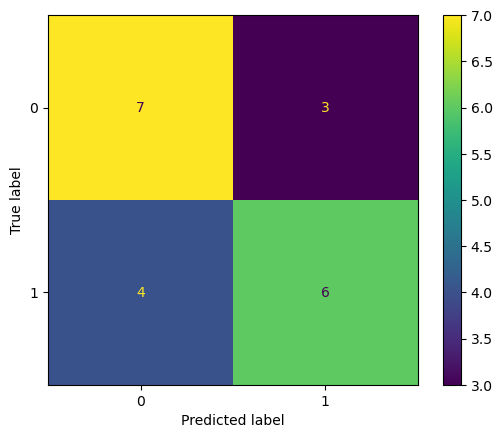

In [163]:
y_pred = best_clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names = ["Important","Non-Important"]))

cm= ConfusionMatrixDisplay.from_estimator(best_clf, x_test, y_test)

print(clf_search.best_score_, clf_search.best_params_)
print()
print(accuracy_score(y_test,y_pred))

               precision    recall  f1-score   support

    Important       0.45      0.50      0.48        10
Non-Important       0.44      0.40      0.42        10

     accuracy                           0.45        20
    macro avg       0.45      0.45      0.45        20
 weighted avg       0.45      0.45      0.45        20



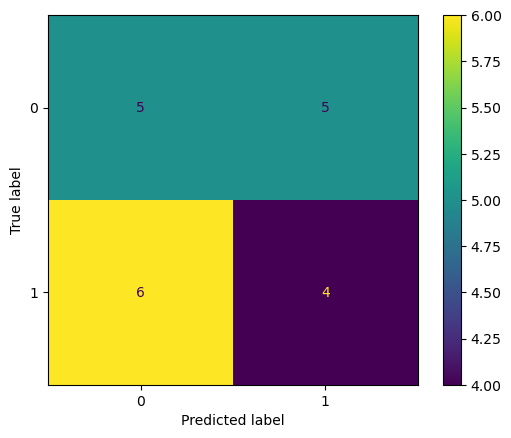

In [173]:
from sklearn.dummy import DummyClassifier
trivial_clf = DummyClassifier(strategy="uniform")
trivial_clf.fit(x_train, y_train)

y_trivial = trivial_clf.predict(x_test)
print(classification_report(y_test, y_trivial, target_names = ["Important","Non-Important"]))

cm= ConfusionMatrixDisplay.from_estimator(trivial_clf, x_test, y_test)


In [174]:
unlabeled_data = updated_data[updated_data["petition_importance"].isna()]
unlabeled_data.head()

,relevant_department,deviation_across_regions,petition_importance,petition_text,has_event,has_date,has_person
100,Department for Education,0.000110,NaN,"[ban, mandatory, uniform, state, school, europ...",0,0,0
101,Department for Education,0.000378,NaN,"[support, gcse, level, exam, impact, covid-19,...",0,0,1
102,Department for Education,0.000142,NaN,"[reform, assessment, english, gcse, believe, c...",0,0,0
103,Department for Education,0.011228,NaN,"[increase, funding, early, year, setting, beli...",0,0,1
104,"Department for Environment, Food and Rural Aff...",0.000059,NaN,"[introduce, legal, minimum, requirement, hamst...",0,0,0


In [175]:
unlabeled_data = unlabeled_data.drop(columns="petition_importance")
unlabeled_data.head()

,relevant_department,deviation_across_regions,petition_text,has_event,has_date,has_person
100,Department for Education,0.000110,"[ban, mandatory, uniform, state, school, europ...",0,0,0
101,Department for Education,0.000378,"[support, gcse, level, exam, impact, covid-19,...",0,0,1
102,Department for Education,0.000142,"[reform, assessment, english, gcse, believe, c...",0,0,0
103,Department for Education,0.011228,"[increase, funding, early, year, setting, beli...",0,0,1
104,"Department for Environment, Food and Rural Aff...",0.000059,"[introduce, legal, minimum, requirement, hamst...",0,0,0


#### by the logic of supervised learning the best_clf model should be trained on the 80 records passed to predict on the other missing records

In [215]:
updated_data["Predicted Importance (Supervised Learning)"] = best_clf.predict(updated_data)



In [230]:
data["Predicted Importance (Supervised Learning)"] = updated_data["Predicted Importance (Supervised Learning)"]

In [231]:
data.to_csv("Predicted_Importance_Dataset.csv")